0.6402805611222445 0.7136420648198696
2.0731462925851702 0.7136420648198696


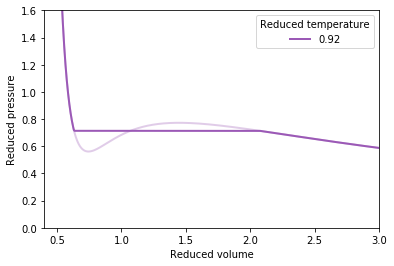

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.signal import argrelextrema

palette = iter(['#9b59b6', '#4c72b0', '#55a868', '#c44e52', '#dbc256'])

# Critical pressure, volume and temperature
# These values are for the van der Waals equation of state for CO2:
# (p - a/V^2)(V-b) = RT. Units: p is in Pa, Vc in m3/mol and T in K.
pc = 7.404e6
Vc = 1.28e-4
Tc = 304

def vdw(Tr, Vr):
    """Van der Waals equation of state.

    Return the reduced pressure from the reduced temperature and volume.

    """

    pr = 8*Tr/(3*Vr-1) - 3/Vr**2
    #-8*Tr*np.log(3*Vr-1) - 3/Vr 
    
    return pr


def vdw_maxwell(Tr, Vr):
    """Van der Waals equation of state with Maxwell construction.

    Return the reduced pressure from the reduced temperature and volume,
    applying the Maxwell construction correction to the unphysical region
    if necessary.

    """

    pr = vdw(Tr, Vr)
    if Tr >= 1:
        # No unphysical region above the critical temperature.
        return pr

    # Initial guess for the position of the Maxwell construction line:
    # the volume corresponding to the mean pressure between the minimum and
    # maximum in reduced pressure, pr.
    iprmin = argrelextrema(pr, np.less)
    iprmax = argrelextrema(pr, np.greater)
    Vr0 = np.mean([Vr[iprmin], Vr[iprmax]])

    def get_Vlims(pr0):
        """Solve the inverted van der Waals equation for reduced volume.

        Return the lowest and highest reduced volumes such that the reduced
        pressure is pr0. It only makes sense to call this function for
        T<Tc, ie below the critical temperature where there are three roots.

        """

        eos = np.poly1d( (3*pr0, -(pr0+8*Tr), 9, -3) )
        roots = eos.r
        roots.sort()
        Vrmin, _, Vrmax = roots
        return Vrmin, Vrmax

    def get_area_difference(Vr0):
        """Return the difference in areas of the van der Waals loops.

        Return the difference between the areas of the loops from Vr0 to Vrmax
        and from Vrmin to Vr0 where the reduced pressure from the van der Waals
        equation is the same at Vrmin, Vr0 and Vrmax. This difference is zero
        when the straight line joining Vrmin and Vrmax at pr0 is the Maxwell
        construction.

        """

        pr0 = vdw(Tr, Vr0)
        Vrmin, Vrmax = get_Vlims(pr0)
        return quad(lambda vr: vdw(Tr, vr) - pr0, Vrmin, Vrmax)[0]

    # Root finding by Newton's method determines Vr0 corresponding to
    # equal loop areas for the Maxwell construction.
    Vr0 = newton(get_area_difference, Vr0)
    pr0 = vdw(Tr, Vr0)
    Vrmin, Vrmax = get_Vlims(pr0)

    # Set the pressure in the Maxwell construction region to constant pr0.
    pr[(Vr >= Vrmin) & (Vr <= Vrmax)] = pr0
    return pr

Vr = np.linspace(0.5, 3, 500)

def plot_pV(T):
    Tr = T / Tc
    c = next(palette)
    ax.plot(Vr, vdw(Tr, Vr), lw=2, alpha=0.3, color=c)
    ax.plot(Vr, vdw_maxwell(Tr, Vr), lw=2, color=c, label='{:.2f}'.format(Tr))
    print(Vr[28],vdw_maxwell(Tr, Vr)[28])
    print(Vr[314],vdw_maxwell(Tr, Vr)[314])
fig, ax = plt.subplots()

plot_pV(280)

ax.set_xlim(0.4, 3)
ax.set_xlabel('Reduced volume')
ax.set_ylim(0, 1.6)
ax.set_ylabel('Reduced pressure')
ax.legend(title='Reduced temperature')

print

plt.show()